In [1]:
# add autoreload
%load_ext autoreload
%autoreload 2
import sickle
from tqdm import tqdm
import os

import requests
import lxml
import bs4
import random
from time import sleep

import oai



import pandas as pd

import dotenv
dotenv.load_dotenv()

True

In [2]:
import openai
import asyncio
from openai import AsyncOpenAI, OpenAI
openai.api_key = os.getenv("OPENAI_KEY")

In [3]:
source = 'UVA'

In [4]:
accepted_topiclist = ['athero', 
                        'plaque', 
                        'cardiovascular',
                        'cardiogram', 
                        'cardiology', 
                        'cardiologie',
                        'hartvaten',
                        'klinsch',
                        'medische',
                        'hartvaat',
                        'heart', 
                        'vascular',
                        'angiogram', 
                        'cardiologie', 
                        'hartziekte', 
                        'vaatziekte',
                        'medicine',
                        'disease', 
                        'medical', 
                        'therapy',
                        'therapeutic',
                        'diagnosic',
                        'clinical',
                        'surgical', 
                        'metabolic',
                        'myocard']

accepted_topiclist = ['recht', 'wetten', 'juridisch',
                      'rechtspraak', 'verordering', 'wetgeving',
                      'richtlijn',
                      'regelgeving',
                      'wetboek', 'bevoegdheid', 'toezicht',
                      'wetboek', 'jurisprudentie', 
                      'precedent', 'wet bibop',
                      'wetboek van strafrecht',
                      'wetboek van strafvordering']

accepted_dtypes = ['doctoral', 'book', 'article']
accepted_languages = ['nl','nld','dut', 'und'] 


base_url =   oai.sources[source]['link'] #'https://repository.ubn.ru.nl/oai/openaire'  https://scholarlypublications.universiteitleiden.nl/oai2, http://dspace.library.uu.nl/oai/dissertation
pdf_path = f'//Ds/data/LAB/laupodteam/AIOS/Bram/language_modeling/MEDICAL_TEXT/RAW/PhDTheses/{source}/'
pdf_path = f'/media/koekiemonster/DATA-FAST/text_data/pubscience/PDF/LAW/RUG' 

In [5]:
OpenAIRE_institutes = ['VU', 'UVA', 'Maastricht',
                       'Tilburg', 'RUG', 'UTwente', 
                       'TUE', 'UU', 'Erasmus']

In [6]:
sickler = sickle.Sickle(base_url)

In [7]:
sets = sickler.ListSets()

In [8]:
Sets = {}
for s in sets:
    Sets[s.setSpec]  = s.setName    

In [9]:
keywords = ['clinical', 'medisch', 'medical', 'dissertation', 'umc', 'medicine',
            'diss', 'phd', 'thesis', 'doctorate', 'dissertatie', 'doctoralthesis',
            'doctoraat', 'proefschrift']
if source in OpenAIRE_institutes:
    keywords = keywords + ['publications:withfiles']

Sets_to_mine = []
for key, val in Sets.items():
    #print(key,val)
    if any([c in val.lower() for c in keywords]) | any([c in key.lower() for c in keywords]):
        print(f'Set: {key} contains keyword')
        Sets_to_mine.append(key)

Set: publications:withFiles contains keyword


In [10]:
# get records 
# Beware: this takes a long time.
from collections import defaultdict
records_lists = defaultdict(list)
for set_to_mine in Sets_to_mine:
    #if set_to_mine in ['com_1874_298213']:
    #    continue
    print(f"Mining from set: {set_to_mine}")
    try:
        records = sickler.ListRecords(metadataPrefix='oai_dc', 
                                    ignore_deleted=True, 
                                    set=set_to_mine) # dissertation com_1874_298213
        for record in tqdm(records):
            records_lists[set_to_mine].append(record)
    except Exception as e:
        print(e)
        continue

Mining from set: publications:withFiles


62446it [30:16, 34.39it/s]


## Semantic search

1. generic bi-encoder model
2. generate seed-phrases from the search terms using GPT4
3. use the seed-phrases to search for similar documents


In [11]:
# generate seed phrases with GPT-4
N_phrases = 50
seed_keywords = accepted_topiclist

# make seed phrases
#
prompt = f"""Please, make {N_phrases} sentences related to the list of keywords that is provided by the user.\n.
Requirements: \n
The output MUST be in Dutch. \n
The output MUST ONLY contain the the list created sentences, seperated by a newline.
"""

OAI_ASYNC_CLIENT = AsyncOpenAI(api_key=os.getenv("OPENAI_KEY"), max_retries=2)
OAI_CLIENT = OpenAI(api_key=os.getenv("OPENAI_KEY"), max_retries=2)


def get_chat_res(USER_TEXT='Good day', 
                 SYSTEM_PROMPT=prompt, 
                 n = 1,
                 MODEL="gpt-4"):
    return OAI_CLIENT.chat.completions.create(
            model=MODEL,
            n = n,
            messages=[
                        {"role": "system",
                        "content": SYSTEM_PROMPT
                        },
                        {"role": "user", 
                        "content": USER_TEXT
                        }],
            stream=False,
        )
    
GPT_VERSION = 'gpt-4-1106-preview'


In [12]:
phrases = get_chat_res(USER_TEXT="\n".join(seed_keywords), 
                       SYSTEM_PROMPT=prompt,
                       n=1,
                       MODEL=GPT_VERSION)

In [13]:
SEED_PHRASES = phrases.choices[0].message.content.split('\n')

In [14]:
# TODO ADD SEMANTIC SEARCH 
from sentence_transformers import SentenceTransformer

# 'paraphrase-multilingual-mpnet-base-v2'

SBERT = SentenceTransformer('NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers')

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/408k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/697k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
filtered_records_lists = defaultdict(list)
excluded_records_lists = defaultdict(list)

cond_list = []

RAW_MINE_RESULTS = {}

for set_to_mine in Sets_to_mine:
    relevant_counter = 0
    for idx, r in tqdm(enumerate(records_lists[set_to_mine])):
        _id = f'{set_to_mine}_{idx}'
        meta = r.get_metadata()
        relevant = False
        
        TOPIC = False
        PDF = False
        DOCTORATE = True if 'dissertation' in set_to_mine.lower() else False
        EMBARGO = False
        LANG = False
        
        try:
            _lang = meta['language'][0]
        except KeyError:
            _lang = 'unknown'
            
        if _lang.strip().lower() in accepted_languages:
            LANG = True
        

        if source in ['Radboud']: 
            PDF=True
        
        try:
            _subj = ",".join(meta['subject'])
            if any([t in _subj.lower() for t in accepted_topiclist]):
                TOPIC = True
        except:
            _subj = ""
            pass

        try:
            _title = meta['title']
            if any([t in subj.lower() for subj in _title for t in accepted_topiclist]):
                TOPIC = True
        except:
            _title = ""
            pass

        try:
            _description = meta['description']
            if any([t in subj.lower() for subj in _description for t in accepted_topiclist]):
                TOPIC = True
        except:
            _description = ""
            pass                        
        
        try:
            _format = meta['format'][0].lower()
            if ('pdf' in _format):
                PDF = True
        except:
            _format = ""
            pass
        
        try:
            _type = meta['type'][0].lower()
            if any([t in _type for t in accepted_dtypes]):
                DOCTORATE = True
        except:
            _type = ""
            pass

        try:
            _rights = meta['rights'][0].lower()
            if ('embargo' in _rights) |\
                    ('restricted' in _rights):
                EMBARGO = True
        except:
            _rights = ""
            pass  
        
        try:
            _date = meta['date'][0].lower()
        except:
            _date = ""
            pass
        
        RAW_MINE_RESULTS[_id] = {                
                                'LANG': _lang,
                                'TOPIC': _subj,
                                'TITLE': _title,
                                'DESCRIPTION': _description,            
                                'FORMAT': _format,
                                'TYPE': _type,
                                'RIGHTS': _rights,
                                'DATE': _date,
                                'TOPIC_OF_INTEREST': TOPIC,
                                'META': meta
                              }
        
        
        cond_list.append({'Topic': TOPIC, 
                          'PDF': PDF, 
                          'Doctorate': DOCTORATE, 
                          'Embargo': EMBARGO,
                          'LANG': LANG}
                         )
        
        if TOPIC & PDF & DOCTORATE & LANG & ~EMBARGO:
            relevant_counter += 1
            filtered_records_lists[set_to_mine].append(r)
        else:
            excluded_records_lists[set_to_mine].append(r)

    print(f'Found {relevant_counter} relevant records in set: {set_to_mine}')      

62446it [00:10, 5678.64it/s]

Found 1316 relevant records in set: publications:withFiles


In [16]:
# Collect the embeddings
for k, doc in tqdm(RAW_MINE_RESULTS.items()):
    TEXT = " ".join(doc['TITLE']) + " ".join(doc['DESCRIPTION'])
    EMB = SBERT.encode(TEXT)
    RAW_MINE_RESULTS[k]['EMB'] = EMB

100%|██████████| 62446/62446 [1:34:35<00:00, 11.00it/s]


In [17]:
SEED_PHRASE_EMBEDDINGS = {}
for i,d in enumerate(SEED_PHRASES):
    SEED_PHRASE_EMBEDDINGS[i] = SBERT.encode(d)

In [18]:
from scipy.spatial.distance import cosine
cos_sim = lambda x,y: 1-cosine(x,y)

In [19]:
# get the most similar seed phrase
for k, doc in tqdm(RAW_MINE_RESULTS.items()):
    SIMILARITY = []
    for i, seed_emb in SEED_PHRASE_EMBEDDINGS.items():
        SIMILARITY.append(cos_sim(seed_emb, doc['EMB']))
    RAW_MINE_RESULTS[k]['SIMILARITY'] = SIMILARITY

100%|██████████| 62446/62446 [01:04<00:00, 964.36it/s] 


In [22]:
sem_filtered =  []
for k, doc in tqdm(RAW_MINE_RESULTS.items()):
    if any([s > 0.50 for s in doc['SIMILARITY']]):
        sem_filtered.append(k)    
len(sem_filtered)

100%|██████████| 62446/62446 [00:00<00:00, 297460.13it/s]


300

In [28]:
seed_emb_df = pd.DataFrame.from_dict({f'{k}_SEED':v 
                                      for k,v in SEED_PHRASE_EMBEDDINGS.items()}, orient='index')

result_emb_df = pd.DataFrame.from_dict({k:v['EMB'] 
                                        for k,v in RAW_MINE_RESULTS.items()}, 
                                     orient='index')

In [40]:
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

In [35]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(result_emb_df.values)
pca_seed_result = pca.transform(seed_emb_df.values)

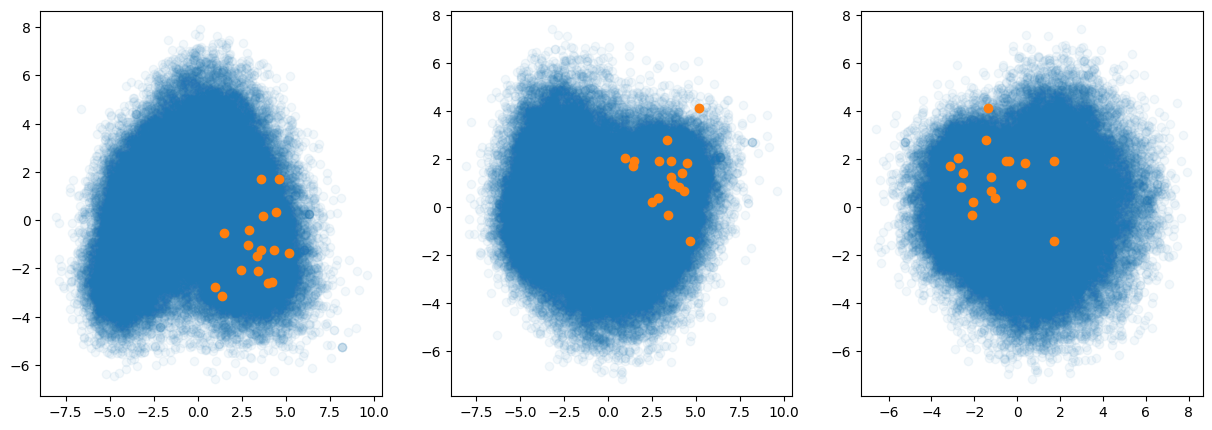

In [50]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(pca_result[:,0], pca_result[:,1], 'o', alpha=0.05)
ax[0].plot(pca_seed_result[:,0], pca_seed_result[:,1], 'o', alpha=1.0)

ax[1].plot(pca_result[:,0], pca_result[:,2], 'o', alpha=0.05)
ax[1].plot(pca_seed_result[:,0], pca_seed_result[:,2], 'o', alpha=1.0)

ax[2].plot(pca_result[:,1], pca_result[:,2], 'o', alpha=0.05)
ax[2].plot(pca_seed_result[:,1], pca_seed_result[:,2], 'o', alpha=1.0)

In [45]:
umapper = UMAP(n_components=3)
umap_result = umapper.fit_transform(result_emb_df.values)
umap_seed_result = umapper.transform(seed_emb_df.values)

/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/nlp/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(-5.0, 10.0)

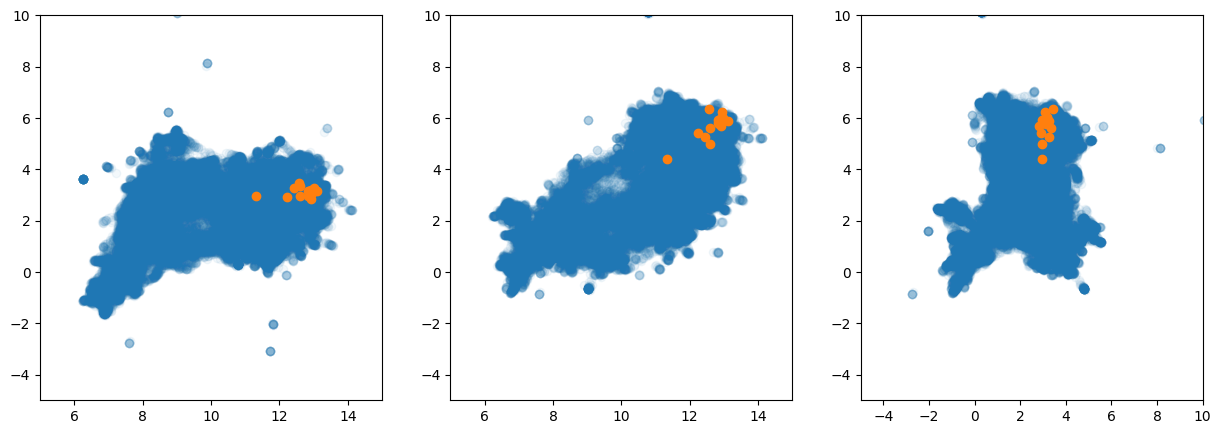

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].plot(umap_result[:,0], umap_result[:,1], 'o', alpha=0.05)
ax[0].plot(umap_seed_result[:,0], umap_seed_result[:,1], 'o', alpha=1.0)
ax[0].set_xlim(5,15)
ax[0].set_ylim(-5,10)

ax[1].plot(umap_result[:,0], umap_result[:,2], 'o', alpha=0.05)
ax[1].plot(umap_seed_result[:,0], umap_seed_result[:,2], 'o', alpha=1.0)
ax[1].set_xlim(5,15)
ax[1].set_ylim(-5,10)

ax[2].plot(umap_result[:,1], umap_result[:,2], 'o', alpha=0.05)
ax[2].plot(umap_seed_result[:,1], umap_seed_result[:,2], 'o', alpha=1.0)
ax[2].set_xlim(-5,10)
ax[2].set_ylim(-5,10)

In [21]:
types_counts = defaultdict(int)
for r in excluded_records_lists['publications:withFiles']:
    try:
        types_counts[r.metadata['type'][0]] += 1
    except:
        pass

In [ ]:
types_counts

In [ ]:
conds_df = pd.DataFrame(cond_list)

In [ ]:
conds_df.sum()

In [ ]:
tot_theses_with_pdf = (conds_df.Doctorate & conds_df.PDF).sum()
print(f"Total number of theses with PDF: {tot_theses_with_pdf}")

In [ ]:
link_list = []
error_list = []

for set_to_mine in filtered_records_lists.keys():
    for record in tqdm(filtered_records_lists[set_to_mine]):
        META = record.get_metadata()
        try:
            List_of_identifiers = META['identifier'] if 'identifier' in META.keys() else ['']
            Title = META['title'] if 'title' in META.keys() else ['']
            Description = META['description'] if 'description' in META.keys() else ['']
            Date = META['date'] if 'date' in META.keys() else ['']
            Language = META['language'] if 'language' in META.keys() else ['']       
            Creator = META['creator'] if 'creator' in META.keys() else ['']
            
            
            List_of_identifiers = [id for id in List_of_identifiers if id is not None]
            
            if len(List_of_identifiers)>0:
                link_list.append({'Set': set_to_mine, 
                                'Link': List_of_identifiers, 
                                'Title': Title,
                                'Description': Description,
                                'Date': Date ,
                                'Language': Language,
                                'Creator': Creator,
                                'Publisher': META.get('publisher'),
                                }
                                )
            else:
                continue
        except Exception as e:
            error_list.append(f"Error parsing {e}: {META}: ")
            pass

In [ ]:
publisher_counts = defaultdict(int)
for r in link_list:
    try:
        publisher_counts[r['Publisher']] += 1
    except:
        pass
publisher_counts

In [ ]:
link_list[500]

In [ ]:
import re

In [ ]:
def get_pdfs_Leiden(url):
    try:
        r = requests.get(url, timeout=10)
        # random number between 0.5 and 2.5 seconds
        rndSleep = round(random.uniform(1, 5), 2)
        sleep(rndSleep)
        soup = bs4.BeautifulSoup(r.text, 'html.parser')
        found, dsfound, esfound = False, False, False
        for _res in soup.findAll('li', {'class':'ubl-file-view'}):
            if _res.a is not None:
                if _res.a.contents[0].strip().lower() == 'full text':
                    _pdfdir = _res.a['href']
                    found = True
                elif _res.a.contents[0].strip().lower() == 'summary in dutch':
                    _dutch_summary = _res.a['href']
                    dsfound = True
                elif _res.a.contents[0].strip().lower() == 'summary in english':
                    _english_summary = _res.a['href']
                    esfound = True

        linkPdfAlt = f"https://scholarlypublications.universiteitleiden.nl{_pdfdir}" if found else None
        DutchSummaryLink = f"https://scholarlypublications.universiteitleiden.nl{_dutch_summary}" if dsfound else None
        EnglishSummaryLink = f"https://scholarlypublications.universiteitleiden.nl{_english_summary}" if esfound else None
        
        return linkPdfAlt, DutchSummaryLink, EnglishSummaryLink, r.status_code
    except Exception as e:
        return None, None, None, None

In [ ]:
def extract_pdf_links(links, institute=None):
    pdf_links = []
    if institute in ['VU', 'UVA', 'UTwente']:
        inclusion_terms = [r'abstract', r'full', r'complete', r'samenvatting', r'summary', r'thesis', r'chapter']
    elif institute in ['Radboud']:
        inclusion_terms = [r'handle', r'bitstream']
    elif institute in ['Maastricht']:
        inclusion_terms = [r'ASSET1', r'c[0-9]{3,4}\.pdf']
    elif institute in ['Tilburg']:
        inclusion_terms = [r'\.pdf']
    elif institute in ['RUG']:
        inclusion_terms = [r'summ\.pdf', r'summary\.pdf',  r'samenv\.pdf', r'samenvat\.pdf', r'[ch][0-9]{1,2}\.pdf', 
                           r'thesis\.pdf', r'proefschrift\.pdf', r'dissertation\.pdf', r'dissertatie\.pdf']
    elif institute in ['TUE']:
        inclusion_terms = [r'summ\.pdf', r'summary\.pdf',  r'samenv\.pdf', r'samenvat\.pdf', r'[ch][0-9]{1,2}\.pdf', 
                           r'thesis\.pdf', r'proefschrift\.pdf', r'dissertation\.pdf', r'dissertatie\.pdf']
        inclusion_terms = inclusion_terms + [r'abstract', r'full', r'complete', r'samenvatting', r'summary', r'thesis', r'chapter']
    elif institute in ['UU']:
        inclusion_terms = [r'dspace\.library\.uu\.nl']
    elif institute in ['Leiden']:
        inclusion_terms = [r'handle']
    elif institute in ['Erasmus']:
        inclusion_terms = [r'files']
    else:
        raise ValueError(f'Institute {institute} not recognized')
    
    inclusion_terms = [re.compile(rs) for rs in inclusion_terms]
    
    if institute in ['UU']:
        _pdf_links = []
        for link in links:
            if (link.lower().startswith('http')):
                baselink = link.replace('dspace.library.uu.nl/', 'dspace.library.uu.nl/bitstream/')
                _pdf_links.append(baselink + '/full.pdf')
        pdf_links = _pdf_links
    elif institute in ['Leiden']:
        _pdf_links = []
        for link in links:
            if (link.lower().startswith('http')) & (any([t.search(link) is not None for t in inclusion_terms])):
                main, dutch_summ, engl_summ, return_code = get_pdfs_Leiden(link)
                if return_code == 429:
                    print("Too many requests. Waiting 60 seconds")
                    sleep(60)
                else:
                    _pdf_links.extend([main, dutch_summ, engl_summ])
        pdf_links = [l for l in _pdf_links if l is not None]
    else:
        for link in links:
            if (link.lower().startswith('http')) & \
                    (link.lower().endswith('.pdf')):
                if any([t.search(link) is not None for t in inclusion_terms]):
                    pdf_links.append(link)        

    return pdf_links

In [ ]:
len(link_list)

In [ ]:
link_pdf_list = []
for l in tqdm(link_list):
    links = extract_pdf_links(l['Link'], institute=source)
    tmp = []
    for _l in links:
        Creator = l['Creator'][0] if l['Creator'][0] is not None else 'Unknown'
        Date = l['Date'][0] if l['Date'][0] is not None else 'Unknown'
        
        pdfPath = _l.split("/")[-1].replace("%20", "_").rstrip('.pdf')
        pdfPath = source + "_" + Creator + "_" + Date + "_" + pdfPath
        pdfPath = pdfPath.replace(",", "")
        pdfPath = pdfPath.replace(":", "")
        pdfPath = pdfPath.replace(".", "")
        pdfPath = pdfPath.replace(" ", "")
        pdfPath = os.path.join(pdf_path, pdfPath+".pdf")
        tmp.append((_l, pdfPath))
    if len(tmp)==0:
        continue
    l['pdf_links'] = tmp
    link_pdf_list.append(l)

In [ ]:
len(link_pdf_list)

In [ ]:
# remove duplicate entries, based on the title
title_set = set()
unique_link_list = []
for el in link_pdf_list:
    try:
        title = el['Title'][0]
        if title not in title_set:
            unique_link_list.append(el)
            title_set.add(title)
    except Exception as e:
        pass

In [ ]:
len(unique_link_list)

In [ ]:
# now we parse the link list and download the pdfs
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36' }

# add sleep
def pdf_writer(pdf_url, _pdf_path):
    r = requests.get(pdf_url, stream=True)
    if r.status_code == 200:
        with open(_pdf_path, 'wb') as f:
            for i,chunk in enumerate(r.iter_content(chunk_size=1024)): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
        return True, 200
    else:
        return False, r.status_code

In [ ]:
if source=='Radboud':
    filelist = os.listdir(pdf_path)
    pre_list = [f.split("_")[-1] for f in filelist]
if source=='UU':
    filelist = os.listdir(pdf_path)
    pre_list = [f.split(".")[-2] for f in filelist]

pdf_error_list = []
skipped_list = []
src_list = []
rcode_list = []
success_list = []
extract_full_text = True
for link in tqdm(unique_link_list):
    for lt in link['pdf_links']:
        _pdf_path = lt[1]
        pdf_url = lt[0]
        return_code = None

        if source=='Radboud':
            if _pdf_path.split("_")[-1] in pre_list:
                skipped_list.append(f'Pdf already exists: {_pdf_path}')
                continue
        if source=='UU':
            if link['pdf_links'][0][0].split("/")[-2] in pre_list:
                skipped_list.append(f'Pdf already exists: {_pdf_path}')
                continue
            
        if os.path.isfile(_pdf_path):
            skipped_list.append(f'Pdf already exists: {_pdf_path}')
        else:
            # try to download the pdf
            try:
                write_file, return_code = pdf_writer(pdf_url, _pdf_path)
                success_list.append(f'Pdf downloaded: {_pdf_path}')
            except Exception as e:
                pdf_error_list.append(f'Error: {e} for link: {link["Link"]}')  

            if return_code == 429:
                print(f'Rate limit exceeded...sleeping 30 seconds')
                sleep(30)
                continue
            else:
                sleep(4)


In [ ]:
print(f'Found {len(pdf_error_list)} errors while downloading pdfs')
print(f'Skipped {len(skipped_list)} pdfs because they already existed')